Todos:
* load dataset and embeddings - done
* create model and train - done
* show result auc roc, recall, pression, training hystory - done
* add dataset statistics/description - done
* add embedings explanation 
* add neural nework explanations(images, video) - done
* add false positive, true positive, false negative analisys (use mostly the same statistics as in the dataset statistics) - done
* write result/inference
* make experiments and save the result into google drive file
> **Experiments ([file](https://docs.google.com/spreadsheets/d/1VnfjCM5kayhn4BFC9Eng9UdKUIE_Ymgs4PdXzMw8fVM/edit?usp=sharing))**

In [1]:
if (!require("keras")) install.packages("keras")
library(keras)
if (!require("tidyverse")) install.packages("tidyverse")
library(tidyverse)
if (!require("qdapRegex")) install.packages("qdapRegex")
library(qdapRegex)
if (!require("data.table")) install.packages("data.table")
library(data.table)
if (!require("readr")) install.packages("readr")
library(readr,warn.conflicts = FALSE,quietly = TRUE)
if (!require("ggplot2")) install.packages("ggplot2")
library(ggplot2,warn.conflicts = FALSE,quietly = TRUE)
if (!require("dplyr")) install.packages("dplyr")
library(dplyr,warn.conflicts = FALSE,quietly = TRUE)
if (!require("tidyr")) install.packages("tidyr")
library(tidyr,warn.conflicts = FALSE,quietly = TRUE)
if (!require("tibble")) install.packages("tibble")
library(tibble,warn.conflicts = FALSE,quietly = TRUE)
if(!require("tidytext")) install.packages("tidytext")
library(tidytext)
if(!require ("wordcloud")) install.packages("wordcloud")
library(wordcloud,warn.conflicts = FALSE,quietly = TRUE)
if(!require ("RColorBrewer")) install.packages("RColorBrewer")
library(RColorBrewer,warn.conflicts = FALSE,quietly = TRUE)
if(!require("reshape2")) install.packages("reshape2")
library(reshape2,warn.conflicts = FALSE,quietly = TRUE)
if (!require("caret")) install.packages("caret")
library(caret) 
library(ROCR)

Loading required package: keras
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1.9000     ✔ purrr   0.2.4     
✔ tibble  1.4.2          ✔ dplyr   0.7.4     
✔ tidyr   0.8.0          ✔ stringr 1.2.0     
✔ readr   1.2.0          ✔ forcats 0.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: qdapRegex

Attaching package: ‘qdapRegex’

The following object is masked from ‘package:dplyr’:

    explain

The following object is masked from ‘package:ggplot2’:

    %+%

Loading required package: data.table

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose

Loading required package: tidytext
Loading required package: wordcloud
Loading require

In [2]:

train_data = read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
test_data = read_csv("../input/jigsaw-toxic-comment-classification-challenge/test.csv")

max_words = 130000
maxl = 200

Parsed with column specification:
cols(
  id = col_character(),
  comment_text = col_character(),
  toxic = col_double(),
  severe_toxic = col_double(),
  obscene = col_double(),
  threat = col_double(),
  insult = col_double(),
  identity_hate = col_double()
)
Parsed with column specification:
cols(
  id = col_character(),
  comment_text = col_character()
)


[1] "toxic 9.58%,severe_toxic 1%,obscene 5.29%,threat 0.3%,insult 4.94%,identity_hate 0.88%"

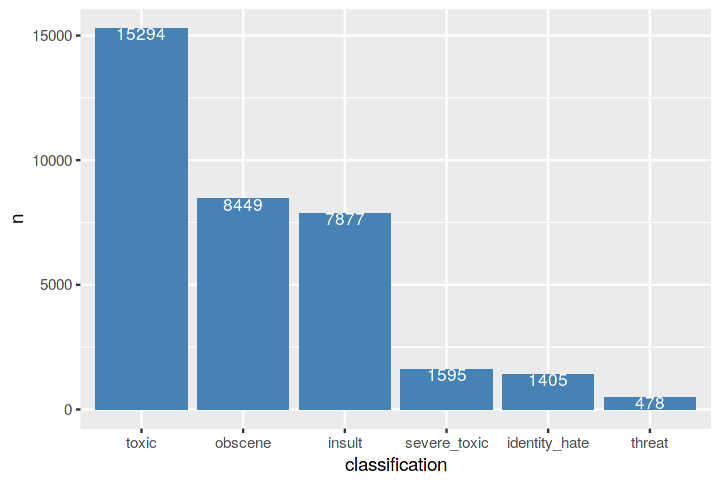

In [3]:
options(repr.plot.width = 6,repr.plot.height=4)

#display percent of dataset that belongs to a certain toxic class
paste(paste0(names(train_data)[3:8]," ",round(100*apply(train_data[,3:8],2,sum)/nrow(train_data),2),"%",collapse = ","))

#Bar plot of class counts
dfm <- data_frame(classification = names(train_data[,3:8]),n=apply(train_data[,3:8],2,sum)) %>% mutate(classification=reorder(classification,-n))
ggplot(data=dfm,aes(x=classification,y=n))+geom_bar(stat="identity",fill = "steelblue")+
    geom_text(aes(label=n),vjust=0.9,color = "white",size = 3.5)

In [4]:
paste0("Comments with more than one class selected: "," ",sum(apply(train_data[,3:8],1,function(x){sum(x)>1})))
paste("Toxic comment along with other classes: ",paste(paste0(names(train_data[,3:8])," ",round(100*apply(train_data[train_data$toxic==1,3:8],2,sum)/apply(train_data[,3:8],2,sum)),"%"),collapse =","))
paste("Obscene comment along with other classes: ",paste(paste0(names(train_data[,3:8])," ",round(100*apply(train_data[train_data$obscene ==1,3:8],2,sum)/apply(train_data[,3:8],2,sum)),"%"),collapse = ","))
paste("insult comment along with other classes: ",paste(paste0(names(train_data[,3:8])," ",round(100*apply(train_data[train_data$insult ==1,3:8],2,sum)/apply(train_data[,3:8],2,sum)),"%"),collapse = ","))
paste("Severe_toxic comment along with other classes: ",paste(paste0(names(train_data[,3:8])," ",round(100*apply(train_data[train_data$severe_toxic ==1,3:8],2,sum)/apply(train_data[,3:8],2,sum)),"%"),collapse = ","))
paste("identity_hate comment along with other classes: ",paste(paste0(names(train_data[,3:8])," ",round(100*apply(train_data[train_data$identity_hate ==1,3:8],2,sum)/apply(train_data[,3:8],2,sum)),"%"),collapse = ","))
paste("threat comment along with other classes: ",paste(paste0(names(train_data[,3:8])," ",round(100*apply(train_data[train_data$threat ==1,3:8],2,sum)/apply(train_data[,3:8],2,sum)),"%"),collapse = ","))

[1] "Comments with more than one class selected:  9865"

[1] "Toxic comment along with other classes:  toxic 100%,severe_toxic 100%,obscene 94%,threat 94%,insult 93%,identity_hate 93%"

[1] "Obscene comment along with other classes:  toxic 52%,severe_toxic 95%,obscene 100%,threat 63%,insult 78%,identity_hate 73%"

[1] "insult comment along with other classes:  toxic 48%,severe_toxic 86%,obscene 73%,threat 64%,insult 100%,identity_hate 83%"

[1] "Severe_toxic comment along with other classes:  toxic 10%,severe_toxic 100%,obscene 18%,threat 23%,insult 17%,identity_hate 22%"

[1] "identity_hate comment along with other classes:  toxic 9%,severe_toxic 20%,obscene 12%,threat 21%,insult 15%,identity_hate 100%"

[1] "threat comment along with other classes:  toxic 3%,severe_toxic 7%,obscene 4%,threat 100%,insult 4%,identity_hate 7%"

In [5]:
tidy_text <- train_data  %>%
  select(id, comment_text, toxic, severe_toxic, obscene, threat, insult, identity_hate) %>%
  unnest_tokens(word, comment_text)

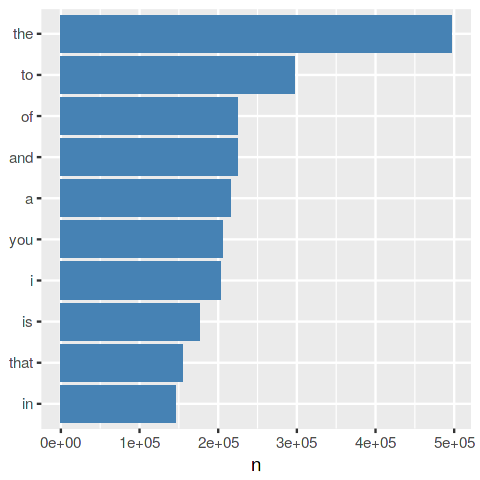

In [6]:
options(repr.plot.width=4,repr.plot.height=4)

tidy_text %>%
    count(word,sort=TRUE) %>%
    head(10) %>%
    mutate(word = reorder(word,n)) %>%
    ggplot(aes(word,n)) +
    geom_col(fill="steelblue") +
    xlab(NULL) +
    coord_flip()

Joining, by = "word"
Joining, by = "word"
Warning message:
“Column `word` joining character vector and factor, coercing into character vector”

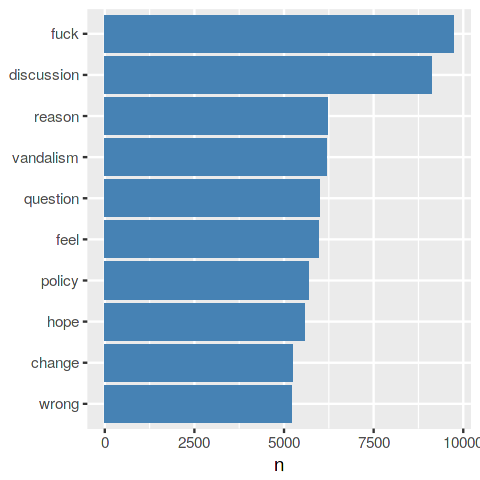

In [9]:
options(repr.plot.width=4,repr.plot.height=4)

#Remove stop words
data(stop_words)
word <- c("links","comments","person","personal","removed","stop","comment","2","1","comment","http","free","blocked","block","editors","note","wikipedia","page","article","talk","edit","people","articles","time","information","deletion","sources","pages","source","editing","section","user","edits","wiki","deleted","add","image","link","list","read","content","utc","history","added")
exter_stopwords<-as.data.frame(word)
tidy_text_nonstops <- tidy_text %>%
    anti_join(stop_words) %>% anti_join(exter_stopwords)

#Plot ten top words
tidy_text_nonstops %>%
    count(word,sort = TRUE) %>%
    head(10) %>%
    mutate(word = reorder(word,n)) %>%
    ggplot(aes(word,n)) +
    geom_col(fill="steelblue") +
    xlab(NULL) +
    coord_flip()

In [10]:
options(repr.plot.width = 7, repr.plot.height = 6)

#Build a frequency table that contains comments of all 6 classes
toxic_comments <- bind_rows(tidy_text_nonstops %>% filter(toxic == 1) %>% select(id,word) %>%
                            count(word,sort=TRUE) %>% mutate(classification = "toxic"),
            tidy_text_nonstops %>% filter(severe_toxic ==1) %>% select(id,word) %>%
                            count(word,sort=TRUE) %>% mutate(classification = "severe_toxic"),
            tidy_text_nonstops %>% filter(obscene == 1)%>% select(id,word) %>%
                            count(word,sort=TRUE) %>% mutate(classification = "obscene"),
            tidy_text_nonstops %>% filter(threat == 1) %>% select(id,word) %>%
                            count(word,sort=TRUE) %>% mutate(classification = "threat"),
            tidy_text_nonstops %>% filter(insult == 1) %>% select(id,word) %>%
                            count(word,sort =TRUE) %>% mutate(classification="insult"),
            tidy_text_nonstops %>% filter(identity_hate ==1) %>% select(id,word) %>%
                            count(word,sort = TRUE) %>% mutate(classification="identity_hate")) %>%
            mutate(classification = as.factor(classification),words = as.factor(word)) %>% select(classification,word,n)


Selecting by n


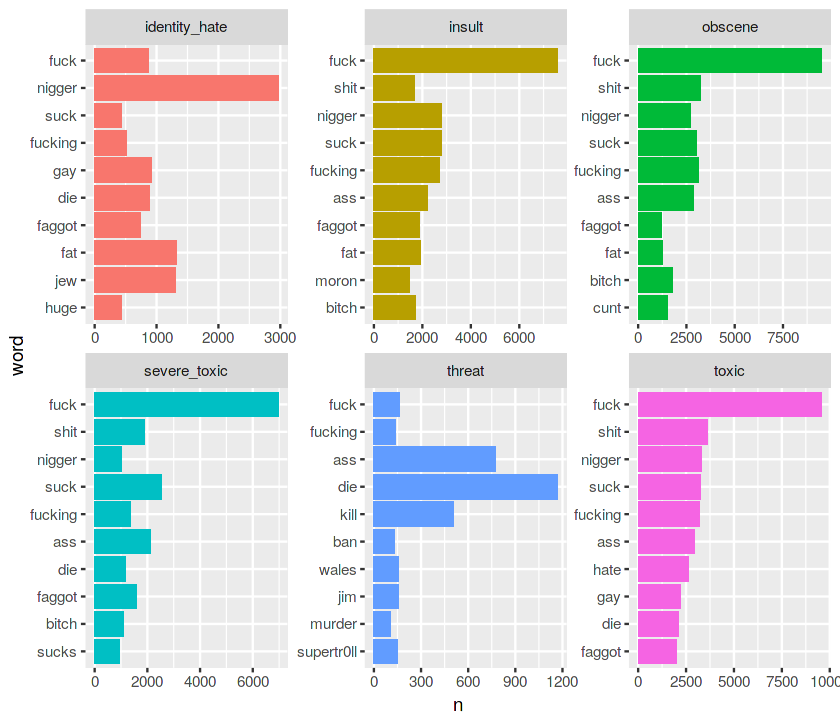

In [11]:
# Plot tops words by classification
toxic_comments %>%
   mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(classification) %>%
  top_n(10) %>%
  ungroup  %>% 
  ggplot(aes(word, n, fill=classification)) +
    geom_bar(show.legend = FALSE, stat="identity") + coord_flip() +
 facet_wrap(~classification, scales="free")

[1] "Wordcloud for  toxic"

Selecting by n


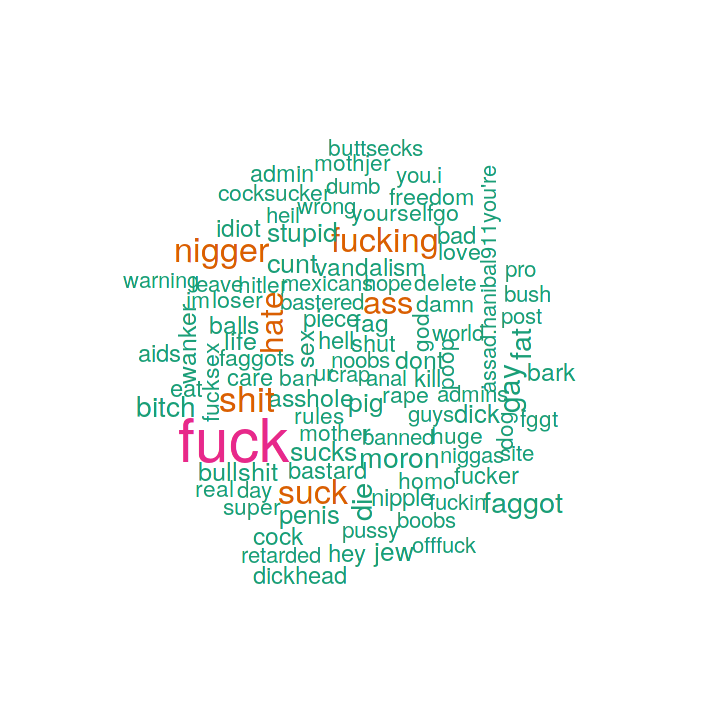

In [12]:
options(repr.plot.width=6,repr.plot.height=6)

#word clouds for classes
paste("Wordcloud for ",names(train_data)[3])
toxic_comments %>%
    filter(classification == names(train_data)[3]) %>%
    top_n(100) %>%
    with(wordcloud(word,n,min.freq = 5,scale = c(3,1),colors = brewer.pal(4,"Dark2")))

[1] "Wordcloud for  severe_toxic"

Selecting by n


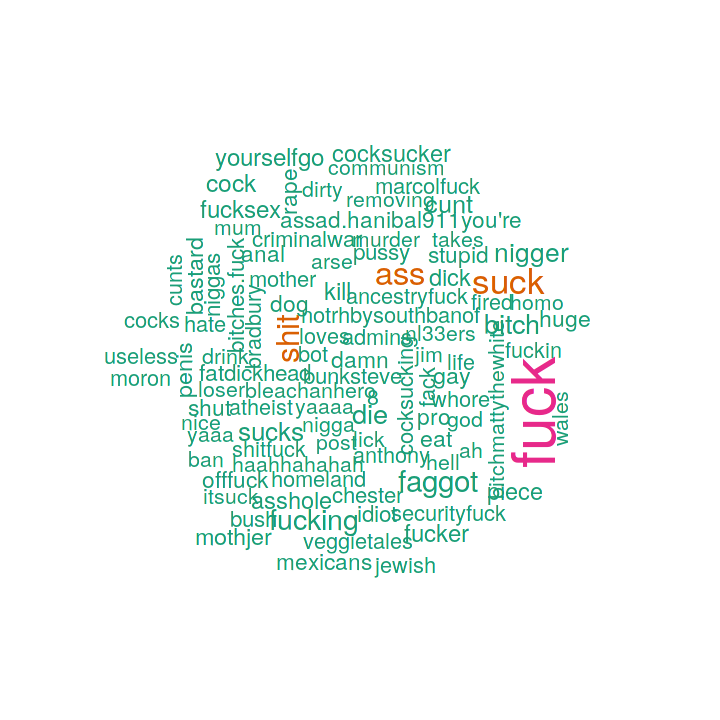

In [14]:
options(repr.plot.width=6,repr.plot.height=6)
paste("Wordcloud for ",names(train_data)[4])
toxic_comments %>%
    filter(classification == names(train_data)[4]) %>%
    top_n(100) %>%
    with(wordcloud(word,n,min.freq = 5,scale = c(3,1),colors = brewer.pal(4,"Dark2")))

[1] "Wordcloud for  obscene"

Selecting by n


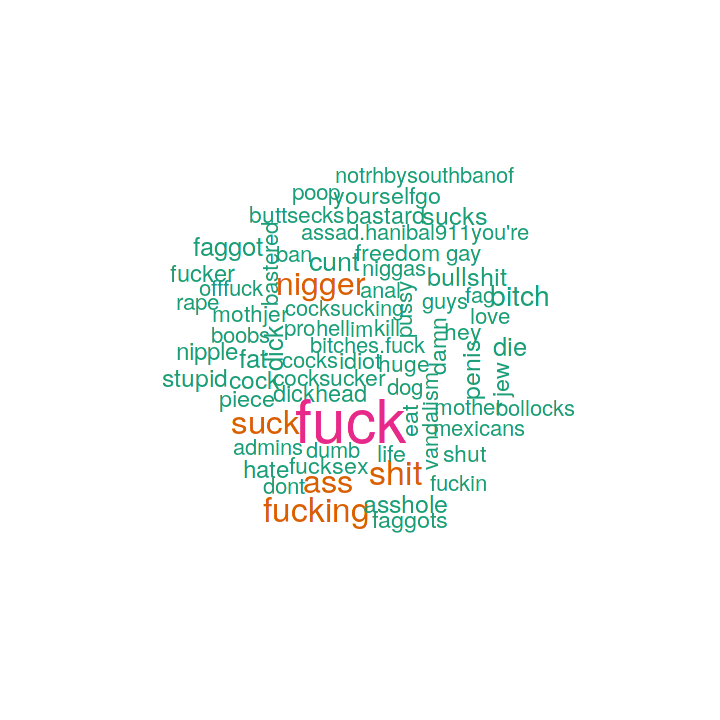

In [15]:
options(repr.plot.width=6,repr.plot.height =6)

paste("Wordcloud for ",names(train_data)[5])

toxic_comments %>%
    filter(classification == names(train_data)[5]) %>%
    top_n(70) %>%
    with(wordcloud(word,n,min.freq = 1,scale = c(3,1),colors = brewer.pal(4,"Dark2")))

[1] "Wordcloud for  threat"

Selecting by n


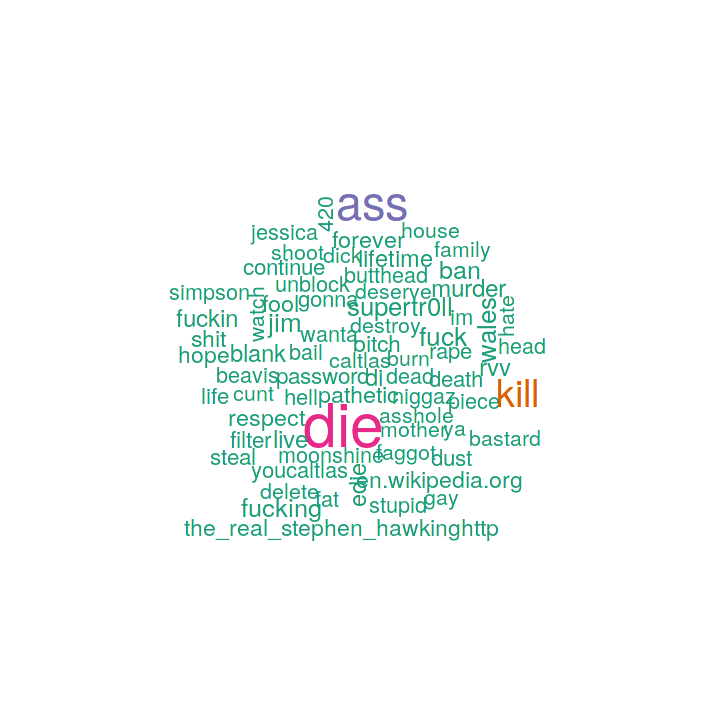

In [16]:
options(repr.plot.width=6,repr.plot.height =6)

paste("Wordcloud for ",names(train_data)[6])

toxic_comments %>%
    filter(classification == names(train_data)[6]) %>%
    top_n(70) %>%
    with(wordcloud(word,n,min.freq = 1,scale = c(3,1),colors = brewer.pal(4,"Dark2")))

[1] "Wordcloud for  insult"

Selecting by n


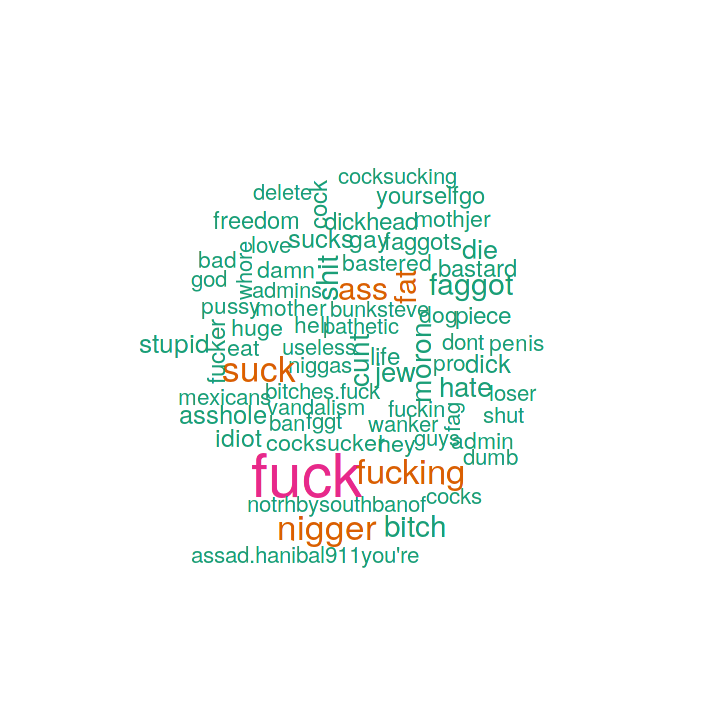

In [17]:
options(repr.plot.width=6,repr.plot.height =6)

paste("Wordcloud for ",names(train_data)[7])

toxic_comments %>%
    filter(classification == names(train_data)[7]) %>%
    top_n(70) %>%
    with(wordcloud(word,n,min.freq = 1,scale = c(3,1),colors = brewer.pal(4,"Dark2")))

[1] "Wordcloud for  identity_hate"

Selecting by n


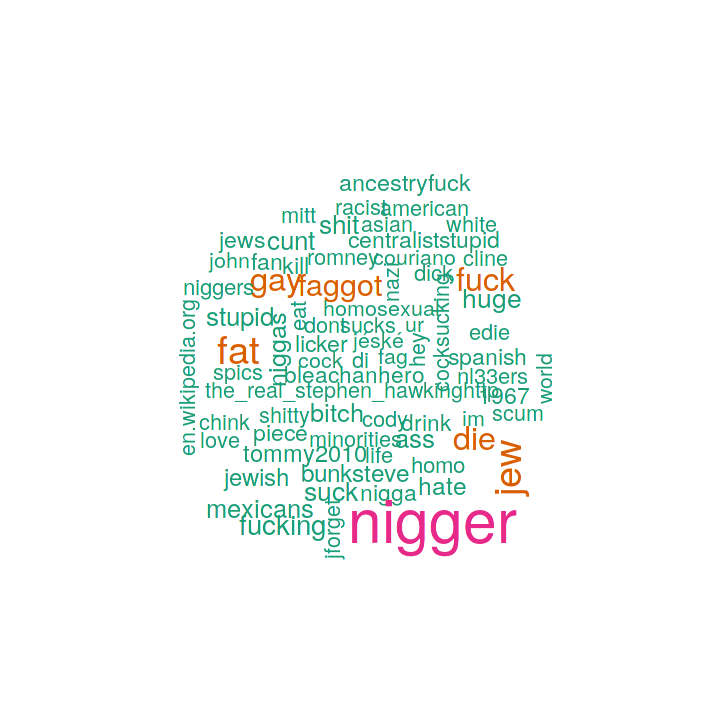

In [18]:
options(repr.plot.width=6,repr.plot.height =6)

paste("Wordcloud for ",names(train_data)[8])

toxic_comments %>%
    filter(classification == names(train_data)[8]) %>%
    top_n(70) %>%
    with(wordcloud(word,n,min.freq = 1,scale = c(3,1),colors = brewer.pal(4,"Dark2")))

In [19]:
#correlation between each class
cor(train_data[,3:8])

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.0000000,0.3086191,0.6765145,0.1570584,0.6475181,0.2660094
severe_toxic,0.3086191,1.0000000,0.4030145,0.1236013,0.3758072,0.2016002
obscene,0.6765145,0.4030145,1.0000000,0.1411790,0.7412724,0.2868669
threat,0.1570584,0.1236013,0.1411790,1.0000000,0.1500224,0.1151283
insult,0.6475181,0.3758072,0.7412724,0.1500224,1.0000000,0.3377363
identity_hate,0.2660094,0.2016002,0.2868669,0.1151283,0.3377363,1.0000000


In [20]:
wordseq = text_tokenizer(num_words = max_words) %>%
        fit_text_tokenizer(c(train_data$comment_text,test_data$comment_text))

In [21]:
#word dictionary
word_index = wordseq$word_index

x_train = texts_to_sequences(wordseq, train_data$comment_text ) %>%
        pad_sequences( maxlen = maxl)
y_train = as.matrix(train_data[,3:8])

x_test = texts_to_sequences(wordseq, test_data$comment_text ) %>%
        pad_sequences( maxlen = maxl)

In [22]:
wgt = fread("../input/glove840b300dtxt/glove.840B.300d.txt", data.table = FALSE)  %>%
        rename(word=V1)  %>%
        mutate(word=gsub("[[:punct:]]"," ", rm_white(word) ))

Read 2156853 rows and 301 (of 301) columns from 5.258 GB file in 00:02:18


In [24]:
#try to split into validation and train
# Shuffle observations   
set.seed(484)
indices <- sample(1:dim(x_train)[1])    
# Split into training and validation sample
prop_train <- .85
train_indices <- 1: round(prop_train*dim(x_train)[1], 0)
val_indices <-  (round(prop_train*dim(x_train)[1], 0)+1) : dim(x_train)[1]
    
x_tr <- x_train[indices[train_indices], ]    
y_tr <- y_train[indices[train_indices], ]
    
x_val <- x_train[indices[val_indices], ]    
y_val <-  y_train[indices[val_indices], ]
y_tr <- as.matrix(y_tr)
y_val <- as.matrix(y_val)

In [25]:
text_val = train_data[indices[val_indices],]
head(text_val)

id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
519c6edce06e329b,Statement I have learned for myself that your beliefs are not true.,0,0,0,0,0,0
769779f022404795,"Dude. You TOTALLY misunderstood what I said. I said i made the account DavidJac123, to be part of the debate, instead of using my IP. I did not say I am Akuri - cause i am not. You misunderstood what i said lol. Just wanted to correct the misunderstanding before everything goes too wild. Anyway I am sorry )",0,0,0,0,0,0
01fb5b0525dd9b05,"Muslim Men Harassment of MM page It is amazing how three muslim men jumped all over this page, right after I added a number of things (30 minutes after - all three men, all muslims), and cleaned it up. Does a woman working for human rights in Pakistan really get under your skin so badly? Wow. So sweetie, if you are so bloody busy, why not get busy, and stop harassing the women? Are you *that* threatened?",1,0,0,0,0,0
e99b4aebab1498f2,""" ===== re: Asma Mohammad Rafi So why did you revert to a version that includes """"Asma is the ugly daughter of an Arabic Omani singer Mohammed Rafi."""" ? I think you're the vandal here. - """,0,0,0,0,0,0
1654d247484625bc,"Fair use rationale for Image:Unsui.gif :Image:Unsui.gif is being used on this article. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in this Wikipedia article constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use. Please go to the image description page and edit it to include a fair use rationale. Using one of the templates at Wikipedia:Fair use rationale guideline is an easy way to insure that your image is in compliance with Wikipedia policy, but remember that you must complete the template. Do not simply insert a blank template on an image page. If there is other fair use media, consider checking that you have specified the fair use rationale on the other images used on this page. Note that any fair use images lacking such an explanation can be deleted one week after being tagged, as described on criteria for speedy deletion. If you have any questions please ask them at the Media copyright questions page. Thank you. Fair use rationale for Image:Watt.gif :Image:Watt.gif is being used on this article. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in this Wikipedia article constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use. Please go to the image description page and edit it to include a fair use rationale. Using one of the templates at Wikipedia:Fair use rationale guideline is an easy way to insure that your image is in compliance with Wikipedia policy, but remember that you must complete the template. Do not simply insert a blank template on an image page. If there is other fair use media, consider checking that you have specified the fair use rationale on the other images used on this page. Note that any fair use images lacking such an explanation can be deleted one week after being tagged, as described on criteria for speedy deletion. If you have any questions please ask them at the Media copyright questions page. Thank you. Fair use rationale for Image:Agon.gif :Image:Agon.gif is being used on this article. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in this Wikipedia article constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale

In [26]:
dic_words = wgt$word
wordindex = unlist(wordseq$word_index)

dic = data.frame(word=names(wordindex), key = wordindex,row.names = NULL) %>%
        arrange(key) %>% 
        .[1:max_words,]

w_embed = dic %>% 
        left_join(wgt)

J = ncol(w_embed)
ndim = J-2
w_embed = w_embed [1:(max_words-1),3:J] %>%
        mutate_all(as.numeric) %>%
        mutate_all(round,6) %>%
        #fill na with 0
        mutate_all(funs(replace(., is.na(.), 0))) 

colnames(w_embed) = paste0("V",1:ndim)
w_embed = rbind(rep(0, ndim), w_embed) %>%
        as.matrix()

Joining, by = "word"
Warning message:
“Column `word` joining factor and character vector, coercing into character vector”

In [27]:
w_embed = list(array(w_embed , c(max_words, ndim)))

**Embeddings**
![image.png](https://qph.fs.quoracdn.net/main-qimg-e8b83b14d7261d75754a92d0d3605e36)

Recurrent Neuronal Netowork
![image.png](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

LSTM
![lstm](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png)

Convolutional Neural Network
![image.png](https://image.slidesharecdn.com/dlsl2017d2l3recurrentneuralnetworksii-170125171005/95/recurrent-neural-networks-ii-d2l3-deep-learning-for-speech-and-language-upc-2017-12-638.jpg?cb=1485365099)

In [ ]:
inp = layer_input(shape = list(maxl),
                  dtype = "int32", name = "input")
emm = inp %>%
        layer_embedding(input_dim = max_words, output_dim = ndim, input_length = maxl, weights = w_embed, trainable=FALSE) 
model = emm %>%
        layer_spatial_dropout_1d(rate=0.1) %>%
        bidirectional( #hyperparameter: how many layers
                layer_gru(units = 40, #hyperparameter
                          return_sequences = TRUE, 
                          recurrent_dropout = 0.1) 
        )# %>% 
#        layer_conv_1d( #hyperparameter: how many layers
#            60, #hyperparameter
#            3, #hyperparameter
#            padding = "valid",
#            activation = "relu",
#            strides = 1
#          ) 

max_pool = model %>% layer_global_max_pooling_1d()
ave_pool = model %>% layer_global_average_pooling_1d()

outp = layer_concatenate(list(ave_pool, max_pool)) %>%
        layer_dense(units = 6, activation = "sigmoid")

model = keras_model(inp, outp)

model %>% compile(
        optimizer = "adam",
        loss = "binary_crossentropy",
        metrics = c("acc")
)

**Binary cross entropy**
![image.png](https://cdn-images-1.medium.com/max/1164/1*PK0iVgkQepmVCprtTgbsGg.png)

In [ ]:
history = model %>% fit(
        x_tr, y_tr,
        epochs = 2,
        batch_size = 32,
        #validation_split = 0.05,
        validation_data = list(x_val,y_val),
        callbacks = list(
                callback_model_checkpoint(paste0("toxic_comment_model.h5"), save_best_only = TRUE),
                callback_early_stopping(monitor = "val_loss", min_delta = 0, patience = 0,
                                        verbose = 0, mode = c("auto", "min", "max"))
        )
)

In [ ]:
model = load_model_hdf5(paste0("toxic_comment_model.h5"))
yhat_val  = model %>%
        predict(x_val, batch_size = 1024) %>%
        as.data.frame()
print(dim(yhat_val))

In [ ]:
y_yval = as.data.frame(y_val) #data frame
th = 0.5#the threshhold, if bigger take as prediction
classid = 1
#head(text_val[which(y_yval[1]>th),])#true toxic comments
#head(text_val[which(yhat_val[1]>th),])#predicted toxic comments
head(text_val[which(yhat_val[classid]>th & y_yval[classid]<th),])#predicted but not toxic comments

In [ ]:
head(text_val[which(yhat_val[classid]<th & y_yval[classid]>th),])#not predicted but toxic comments

In [ ]:
head(text_val[which(yhat_val[classid]>th & y_yval[classid]>th),])# predicted and true toxic comments

In [ ]:
plot(history)

In [ ]:
aucrocResults <- function(y,y_,classes){
    i <- 1
    auct <- 0
    for(cl in classes){
        pred <- prediction(y[i], y_[i])#just first prediction
        perf <- performance(pred, measure = "tpr", x.measure = "fpr")
        # I know, the following code is bizarre. Just go with it.
        auc <- performance(pred, measure = "auc")
        auc <- auc@y.values[[1]]        
        print(c(i, cl, auc))
        auct <- auct + auc
        i <- i + 1
    }
    print(c("total",auct/(i-1)))
}
classes = c("toxic", "severe_toxic", "obscene", "threat","insult", "identity_hate")
aucrocResults(yhat_val, y_yval, classes)#save the output into the spreadsheet on google drive!!!

![image.png](http://algolytics.com/wp-content/uploads/2018/05/roc1_en.png)

In [ ]:
cl = classid2
pred <- prediction(yhat_val[cl], y_yval[cl])#just first class
perf <- performance(pred, measure = "tpr", x.measure = "fpr")
# I know, the following code is bizarre. Just go with it.
auc <- performance(pred, measure = "auc")
auc <- auc@y.values[[1]]

roc.data <- data.frame(fpr=unlist(perf@x.values),
 tpr=unlist(perf@y.values),
 model="GLM")
ggplot(roc.data, aes(x=fpr, ymin=0, ymax=tpr)) +
 geom_ribbon(alpha=0.2) +
 geom_line(aes(y=tpr)) +
 ggtitle(paste0(classes[cl]," : ROC Curve w/ AUC=", auc))#todo: make subplots for each class!
#https://community.alteryx.com/t5/Data-Science-Blog/ROC-Curves-in-Python-and-R/ba-p/138430 --explanations about auc roc